In [65]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.preprocessing
import statsmodels
%matplotlib inline

In [66]:
raw_df=pd.read_csv("analyze.csv")


In [67]:
raw_df.drop(columns='Unnamed: 0',inplace=True,axis=1)

In [68]:
raw_df.columns

Index(['age', 'gender', 'region_category', 'membership_category',
       'joining_date', 'joined_through_referral', 'preferred_offer_types',
       'medium_of_operation', 'internet_option', 'days_since_last_login',
       'avg_time_spent', 'avg_transaction_value', 'avg_frequency_login_days',
       'points_in_wallet', 'used_special_discount',
       'offer_application_preference', 'past_complaint', 'complaint_status',
       'feedback', 'churn_risk_score'],
      dtype='object')

In [69]:
raw_df.dtypes

age                               int64
gender                           object
region_category                  object
membership_category              object
joining_date                     object
joined_through_referral          object
preferred_offer_types            object
medium_of_operation              object
internet_option                  object
days_since_last_login             int64
avg_time_spent                  float64
avg_transaction_value           float64
avg_frequency_login_days        float64
points_in_wallet                float64
used_special_discount            object
offer_application_preference     object
past_complaint                   object
complaint_status                 object
feedback                         object
churn_risk_score                  int64
dtype: object

In [70]:
df=raw_df.copy()

Separate categorical and numerical columns

In [78]:
numeric_data = df.select_dtypes(include=[np.number])
categorical_data = df.select_dtypes(exclude=[np.number])
print(numeric_data.shape[1])
print(categorical_data.shape[1])

7
13


In [ ]:
type(numeric_data)

In [72]:
numeric_data.shape

(36992, 7)

Almost 10% of the data is missing in both avg_frequency_login_days and points_in_wallet

In [79]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values=np.nan, strategy='median')
numeric_data_imputed = pd.DataFrame(imputer.fit_transform(numeric_data),columns = numeric_data.columns)
numeric_data_imputed.isna().sum()

age                         0
days_since_last_login       0
avg_time_spent              0
avg_transaction_value       0
avg_frequency_login_days    0
points_in_wallet            0
churn_risk_score            0
dtype: int64

Correlation between numeric columns and target

In [81]:
numeric_data_corr=numeric_data_imputed[numeric_data_imputed.columns[0:]].corr()['churn_risk_score'][:].sort_values(ascending=False)
numeric_data_corr

churn_risk_score            1.000000
avg_frequency_login_days    0.157056
age                         0.002360
days_since_last_login      -0.009918
avg_time_spent             -0.021052
points_in_wallet           -0.251969
avg_transaction_value      -0.288636
Name: churn_risk_score, dtype: float64

In [82]:
corr = numeric_data_imputed.corr()
# Fill diagonal and upper half with NaNs
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
corr[mask] = np.nan
(corr
 .style
 .background_gradient(cmap='coolwarm', axis=None, vmin=-1, vmax=1)
 .highlight_null(null_color='#f1f1f1')  # Color NaNs grey
 .set_precision(2))

C:\Temp\ipykernel_22140\2031524535.py:6: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  (corr


,age,days_since_last_login,avg_time_spent,avg_transaction_value,avg_frequency_login_days,points_in_wallet,churn_risk_score
age,nan,nan,nan,nan,nan,nan,nan
days_since_last_login,-0.00,nan,nan,nan,nan,nan,nan
avg_time_spent,0.00,-0.00,nan,nan,nan,nan,nan
avg_transaction_value,-0.00,0.00,0.02,nan,nan,nan,nan
avg_frequency_login_days,-0.00,0.00,0.00,-0.13,nan,nan,nan
points_in_wallet,0.00,0.01,-0.00,0.08,-0.04,nan,nan
churn_risk_score,0.00,-0.01,-0.02,-0.29,0.16,-0.25,nan


We can drop columns without any correlation to target variable like days_since_last_login,
age,avg_time_spent

In [84]:
numeric_data_imputed.drop(columns=['days_since_last_login','age','avg_time_spent'],inplace=True,axis=1)

The remaining numeric features are not correlated from the above diagram
Let's check for constant variance

In [ ]:
from scipy import stats
import pylab

In [ ]:
def normality(data,feature):
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    sns.kdeplot(data[feature])
    plt.subplot(1,2,2)
    stats.probplot(data[feature],plot=pylab)
    plt.show()



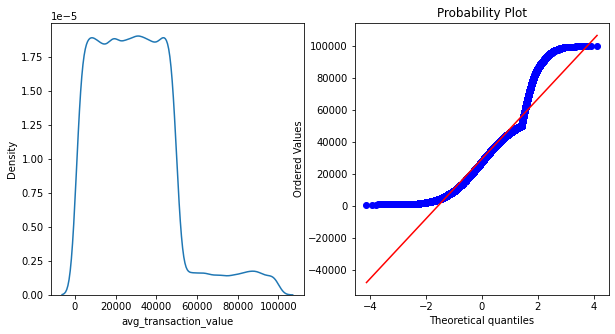

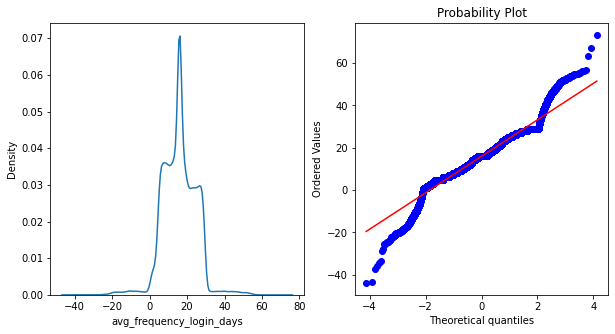

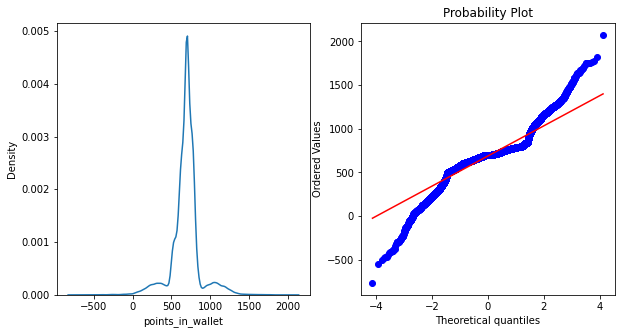

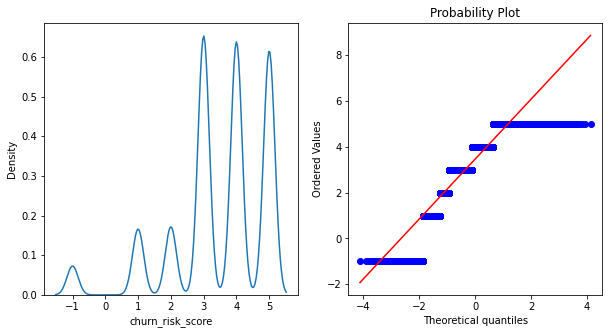

In [85]:
for i in numeric_data_imputed.columns:
    normality(numeric_data_imputed,i)

c:\Home\Git\ChurnRiskRate\ChurnRiskRate\venv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


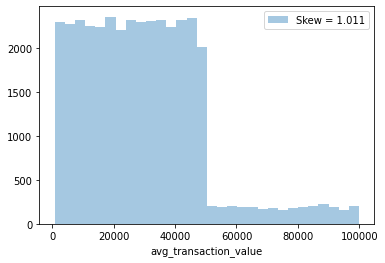

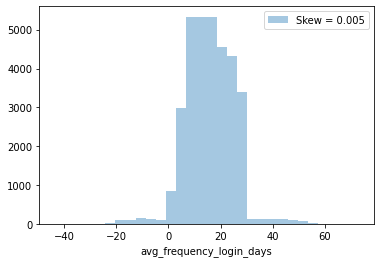

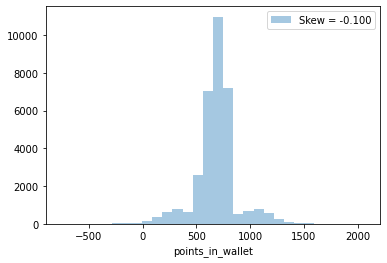

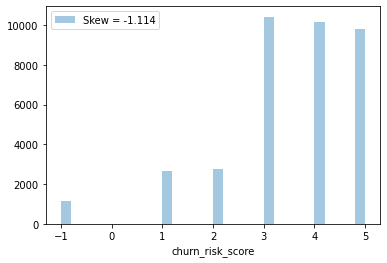

In [86]:
for feat in numeric_data_imputed.columns:
    skew = numeric_data_imputed[feat].skew()
    sns.distplot(df[feat], kde=False, label='Skew = %.3f' %(skew), bins=30)
    plt.legend(loc='best')
    plt.show()

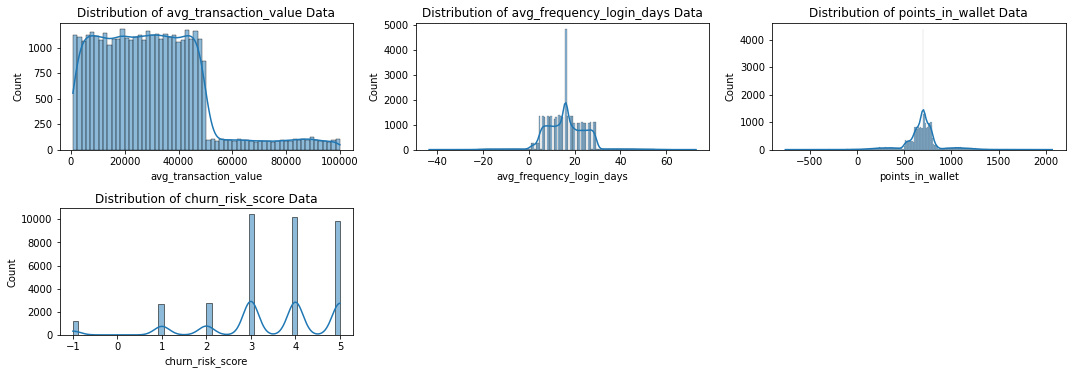

In [87]:
plt.figure(figsize=(15,10))
for i,col in enumerate(numeric_data_imputed.columns,1):
    plt.subplot(4,3,i)
    plt.title(f"Distribution of {col} Data")
    sns.histplot(numeric_data_imputed[col],kde=True)
    plt.tight_layout()
    plt.plot()

Get number of outliers in the numeric data

In [88]:
def outlier_function(df, col_name):
    first_quartile = np.percentile(np.array(df[col_name].tolist()), 25)
    third_quartile = np.percentile(np.array(df[col_name].tolist()), 75)
    IQR = third_quartile - first_quartile 
    upper_limit = third_quartile+(3*IQR)
    lower_limit = first_quartile-(3*IQR)
    outlier_count = 0
    for value in df[col_name].tolist():
        if (value < lower_limit) | (value > upper_limit):
            outlier_count += 1
    return lower_limit, upper_limit, outlier_count

In [89]:
for col in  numeric_data_imputed.columns[:10]:
    out=outlier_function(numeric_data_imputed,col)
    if out[2]>0:
        print(f"There are {out[2]} outliers in {col}")

There are 11 outliers in avg_frequency_login_days
There are 1726 outliers in points_in_wallet
